Number of Multiprocessing threads: 31


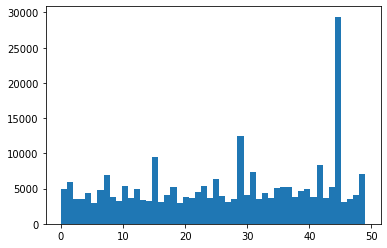

In [1]:
########################################################################
# Q-Learning approach
# First we cluster the trainset by click history and user portraits
# For each cluster, we repeatedly update the Q table;
#     States:  0-8: the number of items that have been recommended
#     Actions: the itemID to be recommended
#     Reward:  (whether the item was purchased) * price of the item
########################################################################
from DataPrep import getClusterLabels
from matplotlib import pyplot as plt
NCLUSTERS = 50
ClusterModel, clusterLabels = getClusterLabels()
plt.hist(clusterLabels, bins = NCLUSTERS)
plt.show()


In [2]:
N_ITEMS = 381
from QLearning import QLearning
from DataPrep import getPurchasedItemsTrainSet
# create array of NCLUSTERS Q tables
QLModels = []
for i in range(NCLUSTERS):
    QLModels.append(QLearning(n_states = N_ITEMS+1, n_actions = N_ITEMS+1))


In [5]:
# prepare data for training
# exposed ItemID: state ID
# next exposed ItemID: action
# initial state = 0
import pandas as pd
import numpy as np
from tqdm import tqdm
rawTrainSet = pd.read_csv('/tf/shared/trainset.csv', ' ')
itemInfo = pd.read_csv('/tf/shared/item_info.csv', ' ')
itemInfo = itemInfo.sort_values(by = 'item_id')
itemPrice = itemInfo.price

exposedItems = rawTrainSet.exposed_items
purchaseLabel = rawTrainSet.labels

for i in tqdm(range(len(exposedItems))):
    exposed_items = exposedItems[i]
    exposed_items = [int(x) for x in exposed_items.split(',')]
    purchase_label = purchaseLabel[i]
    purchase_label = [int(x) for x in purchase_label.split(',')]
    clusterID = clusterLabels[i]
    for j in range(9):
        if j>2 and purchase_label[0]*purchase_label[1]*purchase_label[2]==0:
            # don't train if game stopped
            break
        if j>5 and purchase_label[3]*purchase_label[4]*purchase_label[5]==0:
            # don't train if game stopped
            break
        # first determine the current state
        if j==0:
            state = 0
        else:
            state = exposed_items[j-1]
        # then determine action
        itemID = exposed_items[j]
        action = itemID
        # then determine reward = price * purchased
        reward = itemPrice[itemID-1] * purchase_label[j]
        train_data = np.array([(state, action, reward)])
        QLModels[clusterID].train(train_data)



100%|██████████| 260087/260087 [03:37<00:00, 1194.61it/s]


In [7]:
### predict test set
# predict cluster groups of test set
from DataPrep import getUserFeaturesTestSet
userIDs, userFeaturesTestSet = getUserFeaturesTestSet()
testset_label = ClusterModel.predict(userFeaturesTestSet)

# generate item sets for each test case
output = []
for clusterLabel in tqdm(testset_label):
    recommendedItems = QLModels[clusterLabel].nextNSteps(0, 9)
    output.append(recommendedItems)
    



100%|██████████| 206096/206096 [06:32<00:00, 525.49it/s]

[ 7 33  7 12  5 44  0 33 31 43 10 27 37 15 33  0 12 38 33  0 16 27 27  5
 44 48 45 31 49 25 25 12 29 15 12 15  5 43 19 33 13 37 44 29  5 42 37 12
 42 37]
[[1, 7, 29, 17, 20, 26, 15, 34, 24], [1, 7, 15, 20, 6, 17, 34, 21, 4], [1, 7, 29, 17, 20, 26, 15, 34, 24], [1, 15, 7, 20, 4, 6, 29, 21, 34], [1, 7, 15, 4, 6, 17, 26, 34, 29], [1, 7, 20, 15, 4, 6, 17, 29, 18], [7, 1, 20, 15, 6, 4, 17, 29, 34], [1, 7, 15, 20, 6, 17, 34, 21, 4], [20, 15, 4, 1, 26, 6, 34, 29, 19], [1, 15, 20, 4, 17, 29, 26, 34, 21], [7, 15, 20, 1, 34, 6, 4, 21, 19], [1, 7, 20, 15, 4, 6, 17, 26, 34], [7, 15, 20, 4, 34, 26, 29, 18, 6], [1, 7, 34, 26, 20, 21, 15, 17, 33], [1, 7, 15, 20, 6, 17, 34, 21, 4], [7, 1, 20, 15, 6, 4, 17, 29, 34], [1, 15, 7, 20, 4, 6, 29, 21, 34], [7, 1, 20, 15, 4, 6, 17, 29, 26], [1, 7, 15, 20, 6, 17, 34, 21, 4], [7, 1, 20, 15, 6, 4, 17, 29, 34], [7, 1, 20, 15, 4, 6, 17, 26, 29], [1, 7, 20, 15, 4, 6, 17, 26, 34], [1, 7, 20, 15, 4, 6, 17, 26, 34], [1, 7, 15, 4, 6, 17, 26, 34, 29], [1, 7, 20, 15, 4, 6

In [8]:
# save to output
# format data according to submission format and write to file
outFile = '/tf/shared/track2_output.csv'
f = open(outFile, "w")
f.write('id,itemids')
for i in range(len(userIDs)):
    f.write('\n')
    itemList = output[i]
    itemString = ' '.join([str(j) for j in itemList])
    outString = str(userIDs[i]) + ',' + itemString
    f.write(outString)

In [12]:
##### this part is for testing Metrics
# clusterLabels is cluster labels on train set
# generate recommended item sets for each train case by using QLearning
output_trainset = []
for clusterLabel in tqdm(clusterLabels):
    recommendedItems = QLModels[clusterLabel].nextNSteps(0, 9)
    output_trainset.append(recommendedItems)



100%|██████████| 260087/260087 [08:23<00:00, 516.25it/s]


In [53]:
# from Metrics import *
# from DataPrep import getItemPrice
exposedItems, purchaseLabel = getExposedItemsTrainSet()
itemPrice = getItemPrice()
metrics = Metrics(exposedItems, purchaseLabel, itemPrice)
score = metrics.calculate_metrics1(exposedItems)
print(score) # max score possible

2027136014


In [ ]:
# average item price = 2098
print(sum(itemPrice)/len(itemPrice))

In [54]:
# calculate maximum rewards in Train Set
MaxRewards = 0
for i in range(len(exposedItems)):
# loop through samples
    items = exposedItems[i]
    labels = purchaseLabel[i]
    purchases = [items[k] for k in range(9) if labels[k]==1]
    if i <4:
        print(labels)
        print(items)
        print(purchases)
    for j in purchases:
        MaxRewards = MaxRewards + itemPrice[j-1]

print(MaxRewards)

[1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 20, 28, 99, 86, 119, 213, 237, 164]
[1, 20, 28, 99, 86, 119, 213, 237, 164]
[1, 1, 1, 1, 1, 1, 1, 1, 0]
[1, 4, 26, 112, 86, 117, 191, 234, 172]
[1, 4, 26, 112, 86, 117, 191, 234]
[1, 1, 1, 0, 1, 0, 0, 0, 0]
[22, 4, 28, 48, 105, 42, 193, 236, 159]
[22, 4, 28, 105]
[1, 1, 1, 1, 1, 1, 1, 1, 0]
[5, 16, 1, 74, 133, 122, 235, 218, 172]
[5, 16, 1, 74, 133, 122, 235, 218]
2027136014
